Initialization

In [48]:
import sys
!{sys.executable} -m pip install math

ERROR: Could not find a version that satisfies the requirement math (from versions: none)
ERROR: No matching distribution found for math


In [69]:
import numpy as np
import matplotlib.pyplot as plt
import math

C=np.array([0.,1.])
Sigma_w = 1e-3*np.array([[9.506,0.234],[0.234,9.512]])
Sigma_v = 0.0125
#valeurs à préciser
alpha_1 = 1
alpha_2 = 1
beta = 1

#input and output
y_data = open("Measured_output_nonlinear_case.txt",'r').read().split("\n")[1:-1]
y = np.zeros(len(y_data), dtype='float')
for i in range(len(y_data)):
    y[i] = y_data[i][:-2]
    
u_data = open("Input_nonlinear_case.txt", 'r').read().split("\n")[1:-1]
u = np.zeros(len(u_data), dtype='float')
for i in range(len(u_data)):
    u[i] = u_data[i][:-2]

1. Real State trajectories

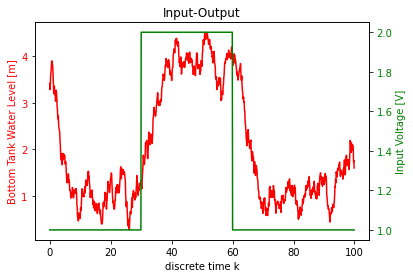

In [70]:
#Visualisation
#plot input-output

fig, ax1 = plt.subplots()
ax1.plot(0.1*np.arange(len(y)),y, '-r',label='Measured Output')
plt.xlabel("discrete time k")
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Bottom Tank Water Level [m]', color='r')
for tl in ax1.get_yticklabels():
    tl.set_color('r')

ax2 = ax1.twinx()
ax2.plot(0.1*np.arange(len(u)),u,'-g', label='Input')
ax2.set_ylabel('Input Voltage [V]', color='g')
for tl in ax2.get_yticklabels():
    tl.set_color('g')  
plt.title("Input-Output")

plt.savefig('IN_OUT.png') 
plt.show()

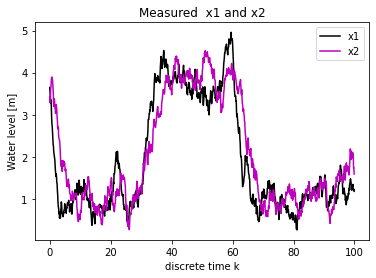

In [71]:
#plot real state x1 and x2

x1_data = open("True_state_x1_nonlinear_case.txt",'r').read().split("\n")[1:-1]
x1 = np.zeros(len(x1_data), dtype='float')
for i in range(len(x1_data)):
    x1[i] = x1_data[i][:-2]

x2_data = open("True_state_x2_nonlinear_case.txt",'r').read().split("\n")[1:-1]
x2 = np.zeros(len(x2_data), dtype='float')
for i in range(len(x2_data)):
    x2[i] = x2_data[i][:-2]
    
plt.plot(0.1*np.arange(len(x1)),x1,'-k', label='x1')
plt.plot(0.1*np.arange(len(x2)),x2,'-m', label='x2')
plt.legend()
plt.xlabel("discrete time k")
plt.ylabel('Water level [m]')
plt.title("Measured  x1 and x2")
plt.savefig('STATES_nonlinear.png')
plt.show()


2. The filtered state (Update step)

In [72]:
h = 0.1
n = 1000
#allocate memory
f = np.zeros((len(y),2,1),dtype='float')
X = np.zeros((len(y),2,1),dtype='float')
Y = np.zeros(len(y),dtype='float')
v = np.zeros(n)
w = np.zeros((n,2))
def F(x, u, k):
    f[k][0] = - alpha_1*np.sqrt(x[k][0]) + beta*u[k]
    f[k][1] = alpha_1*np.sqrt(x[k][0]) - alpha_2*np.sqrt(x[k][1])
    return f

def rungeKutta(x0, y0, u, h):
    for i in range(1, len(y)):
        #Apply Runge Kutta Formulas to find next value of x and y
        f1 = h * F(x0, u, i-1)
        f2 = h * F(x0 + 0.5 * h * f1, u, i-1)
        f3 = h * F(x0 + 0.5 * h * f2, u, i-1)
        f4 = h * F(x0 + h * f3, u, i-1)
 
        # Update next value of x
        x0[i][0] = x0[i-1][0] + (1.0 / 6.0)*(f1[i-1][0] + 2 * f2[i-1][0] + 2 * f3[i-1][0] + f4[i-1][0]) + w[i-1][0]
        x0[i][1] = x0[i-1][1] + (1.0 / 6.0)*(f1[i-1][1] + 2 * f2[i-1][1] + 2 * f3[i-1][1] + f4[i-1][1]) + w[i-1][1]
 
        # Update next value of y
        y0[i] = x0[i][0] + v[i-1]
    return

mu_k = np.zeros((len(y),2,1),dtype='float')
P_k = np.zeros((len(y),2,2),dtype='float')

mu_k[0] = np.random.normal(5.,1.,(2,1))
P_k[0] = np.array([[1.,0.],[0.,1.]])

X[0,:] = np.random.normal(5.,1.,(2,1))
v[0] = np.random.normal(0, Sigma_v)
w[0,:] = np.random.multivariate_normal([0.,0.], Sigma_w)
Y[0] = X[0][1] + v[0]

sol = rungeKutta(X,Y,u,h)
#on calcul maintenant la covariance
Cov_X = np.zeros((2,n),dtype='float')
for i in range (len(y)):
    for j in range(1):
        Cov_X[0][j]=X[i][0]
        Cov_X[1][j]=X[i][1]
    P_k[i] = np.cov(Cov_X)

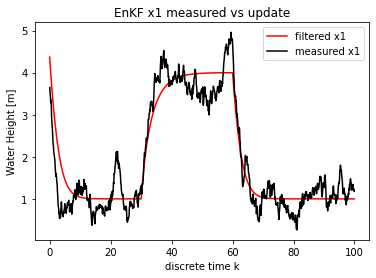

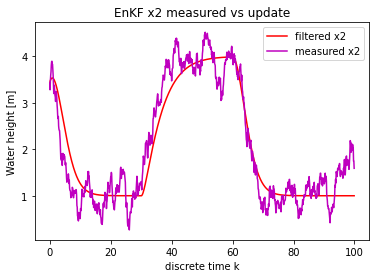

In [73]:
t = 0.1*np.arange(len(x2))

#1e graphe
# fig, ax = plt.subplots()
plt.plot(t, X[:,0,0], '-r',label="filtered x1")
# ax.fill_between(t, mu_k[:,0,0]-1.96*(P_k[:,0,0]**0.5), mu_k[:,0,0]+1.96*(P_k[:,0,0]**0.5) ,alpha=0.3)
plt.plot(t, x1, 'k-',label="measured x1")
plt.legend()
plt.xlabel("discrete time k")
plt.ylabel('Water Height [m]')
plt.title("EnKF x1 measured vs update")
plt.savefig('EnKF_x1_nonlinear_update.png')
plt.show()

#2e graphe
# fig, ax = plt.subplots()
plt.plot(t, X[:,1,0],'-r',label="filtered x2")
# ax.fill_between(t, mu_k[:,1,0]-1.96*(P_k[:,1,1]**0.5), mu_k[:,1,0]-1.96*(P_k[:,1,1]**0.5) ,alpha=0.3)
plt.plot(t, x2, 'm-',label="measured x2")
plt.legend()
plt.xlabel("discrete time k")
plt.ylabel('Water height [m]')
plt.title("EnKF x2 measured vs update")
plt.savefig('EnKF_x2_nonlinear_update.png')
plt.show()

95% confidence intervals

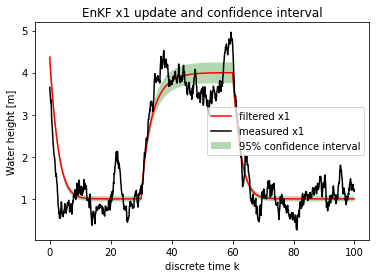

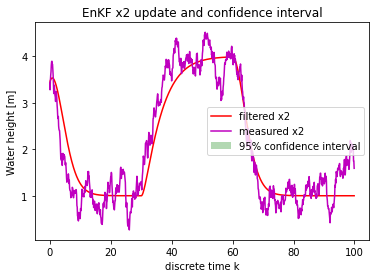

In [74]:
t = 0.1*np.arange(len(x2))

#1e graphe
# fig, ax = plt.subplots()
plt.plot(t, X[:,0,0], '-r',label="filtered x1")
plt.fill_between(t, X[:,0,0]-1.96*(P_k[:,0,0]**0.5), X[:,0,0]+1.96*(P_k[:,0,0]**0.5) ,facecolor='green',alpha=0.3,label="95% confidence interval")
plt.plot(t, x1, 'k-',label="measured x1")
plt.legend()
plt.xlabel("discrete time k")
plt.ylabel('Water height [m]')
plt.title("EnKF x1 update and confidence interval")
plt.savefig('EnKF_nonlinear_x1_update_2.png')
plt.show()

#2e graphe
# fig, ax = plt.subplots()
plt.plot(t, X[:,1,0],'-r',label="filtered x2")
plt.fill_between(t, X[:,1,0]-1.96*(P_k[:,1,1]**0.5), X[:,1,0]-1.96*(P_k[:,1,1]**0.5) ,facecolor='green',alpha=0.3,label="95% confidence interval")
plt.plot(t, x2, 'm-',label="measured x2")
plt.legend()
plt.xlabel("discrete time k")
plt.ylabel('Water height [m]')
plt.title("EnKF x2 update and confidence interval")
plt.savefig('EnKF_nonlinear_x2_update_2.png')
plt.show()

4. Root-Mean-Square Deviation (RMSD) as a function of k

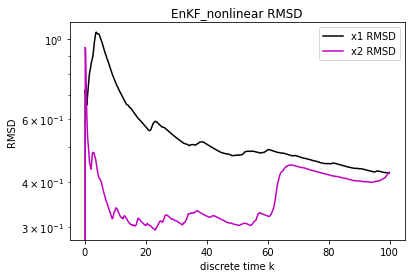

In [75]:
RMSE = np.zeros((len(y),2,1), dtype='float')

def RMSD_k(Pred, Actu1, Actu2, k):
    Actual = np.zeros((k,2,1), dtype='float')
    Predicted = np.zeros((k,2,1), dtype='float')
    for i in range(k):
        Actual[i][0] = Actu1[i]
        Actual[i][1] = Actu2[i]
        Predicted[i][0] = Pred[i][0]
        Predicted[i][1] = Pred[i][0]
    MSD1 = np.square(np.subtract(Predicted[:,0], Actual[:,0])).mean()
    MSD2 = np.square(np.subtract(Predicted[:,1], Actual[:,1])).mean()
    RMSD1 = math.sqrt(MSD1)
    RMSD2 = math.sqrt(MSD2)
    return [[RMSD1],[RMSD2]]

for k in range(1,len(y)):
    RMSE[k] = RMSD_k(X, x1, x2, k)
    

plt.plot(t, RMSE[:,0,0],'-k', label="x1 RMSD")
plt.plot(t, RMSE[:,1,0], '-m',label ="x2 RMSD")
plt.yscale("log")
plt.legend()
plt.title("EnKF_nonlinear RMSD")
plt.xlabel("discrete time k")
plt.ylabel('RMSD')
plt.savefig("EnKF_nonlinear_RMSD.png")
plt.show()
